ChEn-3170: Computational Methods in Chemical Engineering Spring 2024 UMass Lowell; Prof. V. F. de Almeida **25Mar24**

# 10. Shortest Least-Squares Solver
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\yvec}{\boldsymbol{\mathsf{y}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents<a id="toc">
  * [Introduction](#intro)
  * [Detailed Algorithm w/ Wrapper Solve Function](#algo)
  * [Test](#test)
    + [Data](#data)
    + [Compute](#compute)
  * [Another Test](#another)
    + [Data](#anotherdata)
    + [Compute](#anothercompute)
---

## [Introduction](#toc)<a id="intro"></a>

Recall course notes OneNote [ChEn-3170-shortest-lsq-solver](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EqrHIQZxGsdKnllQsn2RmvMBlIFaz2TtXan8aldgK6WWuw?e=Z7EnCh) on computational stoichiometry including an introduction to the linear, rank-deficient, least-squares method.

Compute the solution vector $\xvec$ for a given matrix $\Amtrx$ and right-side vector $\bvec$:

\begin{equation*}
\Amtrx\,\xvec= \bvec .
\end{equation*}

When $\Amtrx$ is rank deficient, $\Amtrx^\top\Amtrx$ is also rank deficient (or singular). The normal equations 

\begin{equation*}
\boxed{\Amtrx^\top\Amtrx\,\xvec_\text{LS}  = \Amtrx^\top\,\bvec },
\end{equation*}

*either have an infinite number of solutions or have no solution*. 

Since $\Amtrx$ is rank deficient, a **unique** mininum-norm least squares solution, $\xvec_\text{MNLS}$, exists as follows,

\begin{equation*}
\min\limits_\xvec \Bigl( \norm{\bvec - \Amtrx\,\xvec_\text{MNLS}}^2 +  \lim\limits_{\epsilon\rightarrow 0}\,\epsilon\,\norm{\xvec_\text{MNLS}}^2 \Bigr) \quad\  \forall \quad\ \xvec.
\end{equation*}

This solution is obtained by solving:

\begin{equation*}
\boxed{
\lim\limits_{\epsilon\rightarrow 0}\,\bigl(\Amtrx^\top\Amtrx + \epsilon\Imtrx\bigr) \xvec_\text{MNLS}  = \Amtrx^\top\,\bvec },
\end{equation*}

where $\Amtrx^\top\Amtrx + \epsilon\Imtrx$ is square, symmetric and full rank. This augmented least-squares problem has a unique solution.

## [Detailed Algorithm w/ Wrapper Solve Function](#toc)<a id="algo"></a>
Refer to course Notebooks [08](https://nbviewer.org/github/dpploy/chen-3170/blob/master/notebooks/08-full-rank-least-squares-reaction-rate.ipynb) and [09](https://nbviewer.org/github/dpploy/chen-3170/blob/master/notebooks/09-rank-deficient-least-squares-reaction-rate.ipynb).

In [1]:
'''Wrapper Shortest LS Solve Function'''

import numpy as np

try:    
    from chen_3170.toolkit import solve   
    from chen_3170.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own solve function here. Bailing out.'
    
def shortest_least_squares_solve(a_mtrx, b_vec, epsilon_min=-8, 
                                 pivoting_option='partial', pivot_tol=1e-8, zero_tol=None, verbose=False):
    if verbose:
        np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
        
    epsilon_values = np.logspace(+2,-7,12)
    
    if matrix_rank(a_mtrx) < min(a_mtrx.shape):
        pivot_tol = epsilon_values[-1]
    
    x_norm_history = list() # return to caller
    phi_tilde_history = list() # return to caller

    for epsilon in epsilon_values:

        if verbose:
            print('')
            print('epsilon = %1.1e'%epsilon)
            print('')

        mtrx = a_mtrx.transpose() @ a_mtrx + epsilon * np.eye(a_mtrx.shape[1]) # AT A + epsilon I, AT A is the normal matrix
        vec  = a_mtrx.transpose() @ b_vec                            # AT b

        # Solve (ATA + epsilon I) x = AT b
        x_vec = solve(mtrx, vec, pivoting_option=pivoting_option, pivot_tol=pivot_tol, zero_tol=zero_tol) # matrix is full rank
        #x_vec = np.linalg.solve(mtrx, vec) # if my solver does not work
        
        x_norm = np.linalg.norm(x_vec)
        if verbose:
            print('||x|| = %8.5e'%x_norm)
    
        x_norm_history.append(x_norm) # save for plotting
    
        # test my solution against NumPy solve
        if verbose:
            print('max(abs(x_vec-x_vec_numpy)) = %2.2e'%np.max(np.abs((x_vec - np.linalg.solve(mtrx, vec)))))
    
        if verbose:
            print('')
        
        residual_vec = b_vec - a_mtrx @ x_vec
        phi_tilde_history.append(np.linalg.norm(residual_vec)**2 + epsilon*x_norm**2)

        if verbose:
            print('||b - A x||^2 + eps*||x||^2 = %8.5e'%phi_tilde_history[-1])
            print('||(ATA-epsI)x - ATb||       = %8.5e'%(np.linalg.norm(mtrx@x_vec-a_mtrx.transpose()@b_vec)))
            print('||b - A x|| +       ||x||   = %8.5e'%(np.linalg.norm(residual_vec) + x_norm))
            print('||b - A x||                 = %8.5e'%(np.linalg.norm(residual_vec)))   

    return (x_vec, (epsilon_values, x_norm_history, phi_tilde_history))

## [Test](#toc)<a id="test"></a>

### [Data](#toc)<a id="data"></a>

In [2]:
'''Any A matrix'''

import numpy as np

nrows = 20
ncols = 32

a = -12.2
b =  88.7

set_rank_deficient = True # set to True or False

a_mtrx = (b-a)*np.random.random((nrows,ncols)) + a
a_mtrx /= a_mtrx.max()

if set_rank_deficient:
    if nrows >= ncols:
        a_mtrx[:,-8:] = 0.0
    if nrows < ncols:
        a_mtrx[-8:,:] = 0.0
        
np.set_printoptions(precision=3, threshold=500, edgeitems=4, linewidth=100)
print('A =\n',a_mtrx)

A =
 [[-6.296e-02 -3.721e-02  8.919e-01 -3.429e-02 ...  7.575e-01  9.756e-01  9.995e-01  9.708e-02]
 [ 8.039e-01  1.931e-01  5.152e-01  5.212e-01 ...  4.452e-01  8.846e-02  5.471e-01  1.699e-01]
 [ 2.579e-01  5.031e-01  5.163e-01  1.980e-01 ...  8.265e-02  9.412e-01  3.051e-01  4.592e-01]
 [ 5.679e-01 -3.872e-04 -8.915e-02 -1.205e-01 ...  8.296e-01  5.581e-01  1.644e-01  2.295e-01]
 ...
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00  0.000e+00]]


In [3]:
'''Rank of A'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

a_rank = matrix_rank(a_mtrx)
print('S shape   = ',a_mtrx.shape)
print('Rank of S = ',a_rank)

if a_rank == min(a_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')
    
assert a_rank == np.linalg.matrix_rank(a_mtrx)

S shape   =  (20, 32)
Rank of S =  12
Matrix is rank deficient.


In [4]:
'''Any right side vector'''

import numpy as np

a = -40.2
b =  3.7

b_vec = (b-a)*np.random.random(nrows) + a # production rates

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
print('b_vec =\n',b_vec)

b_vec =
 [-20.044 -13.532 -23.539  -9.475  -5.203 -33.318  -7.194 -14.834  -0.56  -32.132 -14.798  -1.153
 -33.002 -37.924  -2.966 -12.133  -4.306 -14.748 -30.476   0.138]


### [Compute](#toc)<a id="compute"></a>

In [5]:
'''Compute the MNLS solution'''

# use verbose = True for printout
(x_vec, history) = shortest_least_squares_solve(a_mtrx, b_vec, zero_tol=1e-12)

In [6]:
'''Plot Convergence Function'''

def plot_convergence(history):
    (epsilon_hist, x_norm_hist, phi_tilde_hist) = history
    from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
    #%matplotlib inline
    #plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(figsize=(13,4))
    ax1.semilogx(epsilon_hist, x_norm_hist,'ro--')
    ax1.set_ylabel('MNLS Solution Norm',fontsize=16)
    ax1.set_xlabel('Epsilon',fontsize=16)
    ax1.tick_params(axis='x', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    fig.suptitle('Convergence of Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
    ax1.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)

    ax2 = ax1.twinx()

    ax2.semilogx(epsilon_hist, phi_tilde_hist,'go-')
    ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
    ax2.set_ylabel('Objective Function $\\tilde{\phi}_\epsilon(r)$', fontsize=16)
    plt.show()

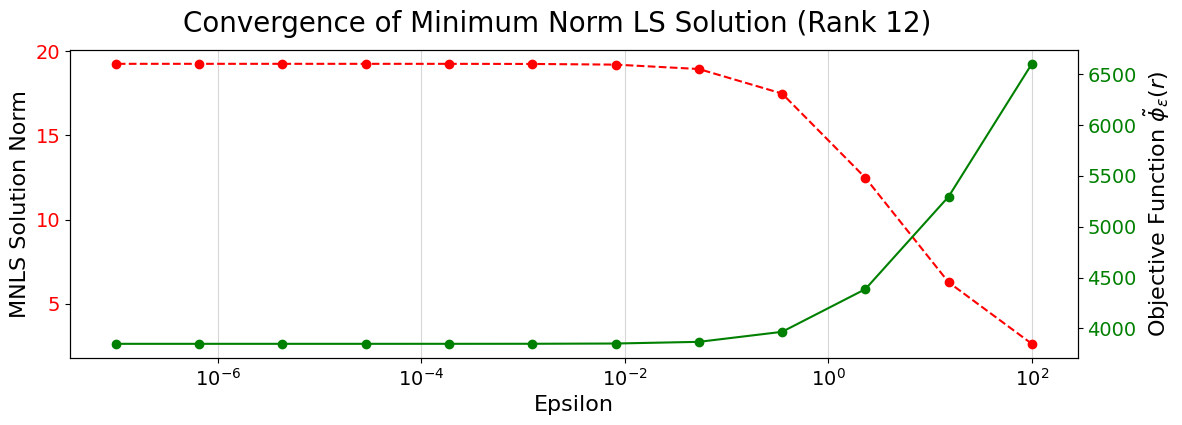

In [7]:
'''Plot Convergence of the Shortest Least-Square Solution Vector'''

plot_convergence(history)

**NB:** Note that from the previous results, the associated rank-deficient $\Amtrx\xvec=\bvec$ has no solution. The computed $\xvec$ is the shortest LS solution of the modified (*regularized*) LS problem.

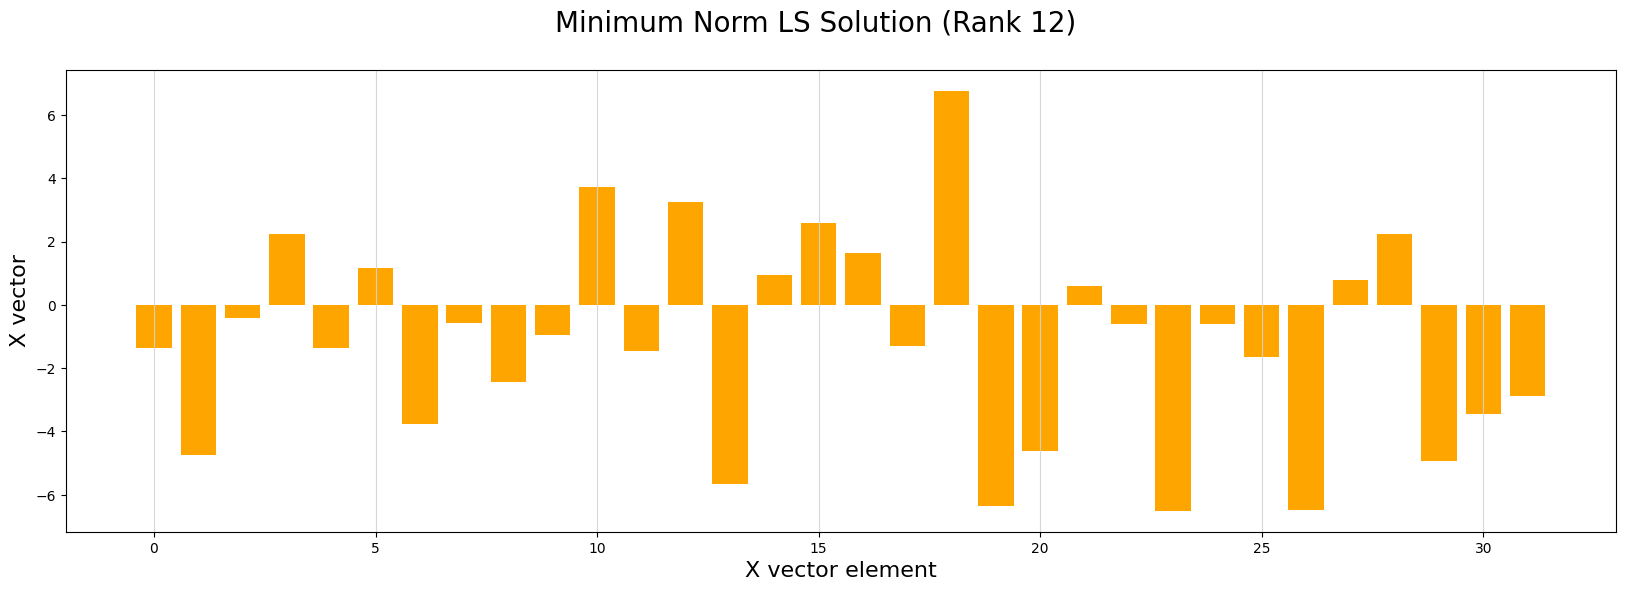

In [8]:
'''Minimum-norm least-squares solution'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(range(x_vec.size), x_vec, color='orange')

ax.set_ylabel('X vector',fontsize=16)
ax.set_xlabel('X vector element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
plt.show()

## [Another Test](#toc)<a id="another"></a>

Compute the solution vector $\xvec$, given $\Amtrx$ and $\bvec$:

\begin{equation*}
\Amtrx\,\xvec= \bvec .
\end{equation*}

### [Data](#toc)<a id="anotherdata"></a>

In [9]:
'''Any A matrix'''

import numpy as np

nrows = 54
ncols = 28

a = -120.2
b =  808.7

set_rank_deficient = True # set to True or False

a_mtrx = (b-a)*np.random.random((nrows,ncols)) + a
a_mtrx /= a_mtrx.max()

if set_rank_deficient:
    if nrows >= ncols:
        a_mtrx[:,-1] = 0.0
    if nrows < ncols:
        a_mtrx[-1,:] = 0.0
        
np.set_printoptions(precision=3, threshold=100, edgeitems=4, linewidth=100)
print('A =\n',a_mtrx)

A =
 [[ 8.318e-01 -1.183e-01  9.379e-01  3.229e-01 ...  1.507e-01  5.487e-01  6.266e-01  0.000e+00]
 [ 7.727e-01  6.863e-01  2.617e-01  8.750e-01 ...  1.990e-01 -5.114e-02  7.321e-01  0.000e+00]
 [ 5.629e-01  4.509e-01  7.147e-01  8.350e-01 ...  3.587e-01  3.659e-01 -9.321e-02  0.000e+00]
 [ 8.509e-02  4.906e-01  6.443e-01  4.056e-01 ...  5.955e-01  8.374e-01 -3.087e-03  0.000e+00]
 ...
 [ 3.440e-02 -5.871e-04  8.196e-01  3.613e-01 ...  6.076e-01  6.738e-01  5.846e-01  0.000e+00]
 [ 6.339e-01  5.652e-01  9.150e-01  5.216e-01 ...  2.552e-01  3.045e-01  6.006e-01  0.000e+00]
 [ 5.326e-01  4.546e-02  4.446e-01  6.857e-01 ...  3.089e-01  3.476e-01  2.441e-02  0.000e+00]
 [-6.295e-02  7.625e-01  5.881e-01  3.671e-02 ... -3.281e-02  1.684e-01  1.531e-01  0.000e+00]]


In [10]:
'''Rank of A'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

a_rank = matrix_rank(a_mtrx)
print('S shape   = ',a_mtrx.shape)
print('Rank of S = ',a_rank)

if a_rank == min(a_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')
    
assert a_rank == np.linalg.matrix_rank(a_mtrx)

S shape   =  (54, 28)
Rank of S =  27
Matrix is rank deficient.


In [11]:
'''Any right side vector'''

import numpy as np

a = -40.2
b =  3.7

b_vec = (b-a)*np.random.random(nrows) + a # production rates

np.set_printoptions(precision=3, threshold=100, edgeitems=3, linewidth=100)
print('b_vec =\n',b_vec)

b_vec =
 [  1.229 -27.976 -21.858 -12.608  -0.753 -28.653 -37.897 -19.674 -27.897 -21.881  -1.721 -28.258
  -9.772  -2.513 -13.829 -27.041  -5.904 -19.751   0.722 -34.307 -20.224 -14.725 -10.574 -30.375
 -17.725   2.096 -37.074 -35.802 -37.063 -26.364 -18.505 -21.963 -12.347 -30.889 -13.109 -25.06
 -30.557 -14.491 -18.581 -29.113 -37.241 -29.607 -35.814 -33.358 -31.972 -21.691 -20.406 -35.059
 -28.648 -14.529 -26.898 -20.536 -32.166 -20.566]


### [Compute](#toc)<a id="anothercompute"></a>

In [13]:
# reusing the wrapper solve function
(x_vec, history) = shortest_least_squares_solve(a_mtrx, b_vec, zero_tol=1e-12)

print('Magnitude of residual vector: ||b - Ax|| = %3.3e'%np.linalg.norm(b_vec-a_mtrx@x_vec))
print('Magnitude of solution vector: ||x|| = %3.3e'%np.linalg.norm(x_vec))

Magnitude of residual vector: ||b - Ax|| = 4.774e+01
Magnitude of solution vector: ||x|| = 3.162e+01


In [14]:
# using an external solve function
try:    
    from chen_3170.toolkit import shortest_least_squares_solve   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'

x_vec = shortest_least_squares_solve(a_mtrx, b_vec, zero_tol=1e-10)

print('Magnitude of residual vector: ||b - Ax|| = %3.3e'%np.linalg.norm(b_vec-a_mtrx@x_vec))
print('Magnitude of solution vector: ||x|| = %3.3e'%np.linalg.norm(x_vec))

Magnitude of residual vector: ||b - Ax|| = 4.774e+01
Magnitude of solution vector: ||x|| = 3.162e+01


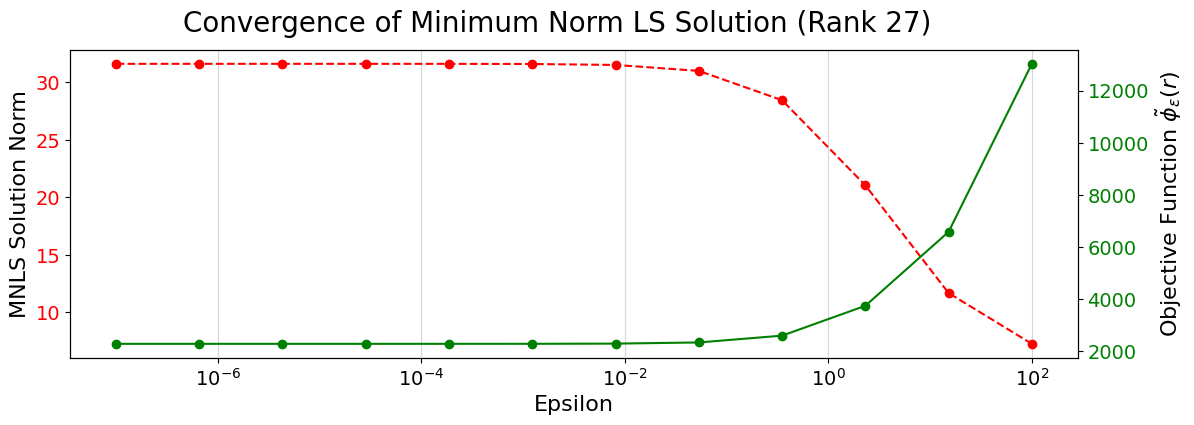

In [15]:
plot_convergence(history)

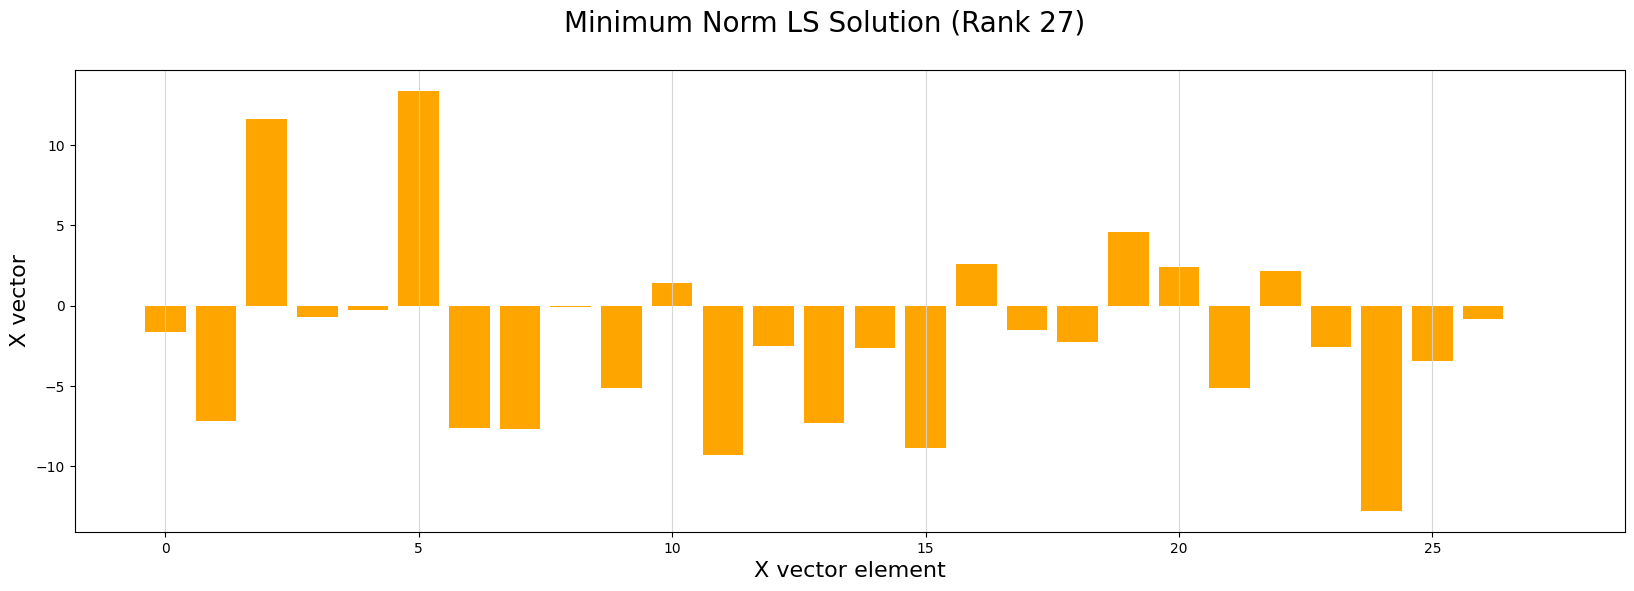

In [16]:
'''Minimum norm least-squares solution'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
#%matplotlib inline
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,6))
ax.bar(range(x_vec.size), x_vec, color='orange')

ax.set_ylabel('X vector',fontsize=16)
ax.set_xlabel('X vector element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Minimum Norm LS Solution (Rank %s)'%str(a_rank),fontsize=20)
plt.show()